# <span id="chap_configuration"></span> Generating arbitrary toplogies: the configuration model

The [ER network](er-networks.ipynb) offers what we term a "simple complex network": the simplest sort of network to exhibit complex properties. The degree distribution is simply Poisson, with the degree of every node being derived independently of every other node. The [power-law network](powerlaw.ipynb) is somewhat more complicated but still follows a mathematically "clean" definition. In both cases there is a single law that creates the networks, controlled by a small number of parameters. While the networks that result from the construction processes are random, they are also highly structured and so are amenable to relatively simple mathematical analysis.

Real-world networks of interest are not typically not so clean. They can actually be less clean in two distinct ways. Firstly, they might exhibit specific degree distributions that are more complicated to capture, for example having no degree-2 nodes but twice as many degree-3 nodes as degree-1 nodes. In this case we may be able to describe the individual degree probabilities without being able to give a function for them. Secondly, they might exhibit different degree distributions for low-degree than for high-degree nodes. A typical example is where a distribution is flat at low degree with a power-law "tail". In this case we want to be able to glue degree distributions together in a way that still allows analysis and simulation.

In this chapter we will describe a technique for generating networks with arbitrary degree distributions, using a Monte Carlo method to create the appropriate edges. This is known as the *configuration model*. It allows us to specify the desired degrees of all the nodes in a network, and then have them wired-up randomly. This means in effect that we can create a list of nodes whose degrees have any distribution we want, coming either from some theoretical source or even observed directly from the real world.

## <span id="sec_configuration_model"></span> Networks with specific degree distributions

When we built an ER network we did so by specifying a generating process and then examining the resulting graph, analytically and in simulation, to derive its degree distribution. Sometimes this is the appropriate approach, and works well when the growth process is the object of study: given this process, what networks arise? These situations frequently occur in experimental science.

There is also the reverse approach, however: given a particular degree distribution, generate a random network whose node degrees have that distribution. This approach can be used to study theoretical results for graphs with different distributions, or to generate the random counterparts of networks whose degree distributions have been collected in the field and for which we may not know the appropriate generating process. This is sometimes called the *configuration model*, and is the approach we will focus on in this chapter, since it allows us to generate networks with *arbitrary* degree distributions, not simply those for which we understand the generating process. Another way to look at this is that we can define a *generic generating process* that can be parameterised by the degree distribution we want.

### <span id="sec_er_network_distribtion"></span> Describing the distribution

Continuous probability distributions are typically given by probability density or cumulative probability functions. However, for networks, the degree distribution is necessarily discrete: all possible degrees of a node are non-negative integers. Therefore the correct way to work with degree distributions is using [probability mass functions](https://en.wikipedia.org/wiki/Probability_mass_function): if $P$ is a probability mass function, then $P(X = k)$ (often written more concisely as $p_k$) is the probability that a random variable $X$ drawn from the distribution has value $k$, where $k$ is an integer and where $P$ is properly normalised so that $\sum_k p_k = 1$. It is often the case that there is a largest possible value of $k$, $k_{max}$, such that $P(X = k) = 0$ for all $k > k_{max}$. $P(X = k)$ can be defined as a function (*i.e.*, as a closed-form expression for any integer value of $k$) or given piecemeal where $k_{max}$ is finite simply by listing the component probabilities.

The closed-form case is exemplified by the ER network description we derived [earlier](er-networks.ipynb#sec_er_networks_mean_degree_maths):

$$p_k = \frac{\langle k \rangle^k e^{-\langle k \rangle}}{k!}$$

In this case there is no $k_{max}$: any value of $k$ is possible, although the probability that a value will appear drops-off rapidly as we move away from the mean degree $\langle k \rangle$.

For the piecemeal case we can specify the probability for each value of $k$ in the legal range, $0 \leq k \leq k_{max}$. The individual probabilities must sum to $1$ for the sequence to be a valid probability distribution.

### Drawing from the distribution

Given a probability distribution, we now need to be able to draw values from it. That is to say, we want to be able to generate a sequence of numbers that exhibit the distribution described by the closed-form or piecemeal description. How do we do this? How do we generate a set of random numbers with a given distribution?

There is a standard technique for accomplishing this called the *Monte Carlo method*, named after the city-state in southern Europe famous for its casinos. The Monte Carlo approach relies on the availability of a source of uniformly distributed random numbers, and from these can generate a sequence of numbers conforming to *any* desired distribution.

Python's random number function `numpy.random.random()` generates uniformly-distributed random numbers in the range $[0 \ldots 1]$ and so can used as the basis for the technique.

In [51]:
# NetworkX for network representation
import networkx as nx

# Some handy mathematical functions
import math
import numpy as np
import numpy.random as rnd

# Data analysis with pandas
import pandas as pd

# Graphics
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import matplotlib.cm as cmx
import seaborn as sns

# High-quality graphics inline
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

To create the set of numbers, we repeatedly do the following:

1. Generate a random number in the range $[0 \ldots 1]$
1. Scale this number up across the values we want to consider. Call this value $k$
1. Compute $p_k$ from the distribution
1. Generate another random number in the range $[0 \ldots 1]$. Call this value $a$
1. If $a \leq p_k$ we *accept* $k'$ as a value; otherwise we *reject* it

We continue this process until we have a set of numbers of the appropriate size $N$.

Rather than generate a list of numbers, which might be very large, we will instead construct a Python class representing a dataset of numbers drawn from an arbitrary distribution.

In [52]:
class Dataset(object):
    """Represent a dataset of numbers drawn from an underlying distribution"""
    
    def __init__( self, n ):
        """Initialise to a dataset.
    
        n: the number of values in the dataset"""
        self._n = n
        self._gen = 0
        
    def __iter__( self ):
        """Use ourselves as the iterator."""
        return self

    def probabilityOf( self, v ):
        """The probability of a value appearing is taken directly from the
        probability mass function. This is a placeholder to be overridden
        in sub-classes.
        
        v: the value
        returns: the probability of this value occurring in the distribution"""
        raise Error("probabilityOf() not overridden in sub-class")

    def _candidate( self ):
        """Generate a candidate value. This is a placeholder to be overridden
        in sub-classes."""
        raise Error("_candidate() not overridden in sub-class")

    def next( self ):
        """Return the next element from the dataset."""
        if self._gen >= self._n:
            raise StopIteration
        else:
            v = self._candidate()
            if rnd.random() < self.probabilityOf(v):
                self._gen = self._gen + 1
                return v
            else:
                return self.next()
        
    def values( self ):
        """Return a list of all the elements remaining in the dataset. Typically
        used instead of iterating."""
        vs = []
        for v in self:
            vs.append(v)
        return vs

We make a class an iterator, allowing its values to be generated as required. The distribution is specified by sub-classing and providing two methods, `candidate()` and `probabilityOf()` which respectively generate a "candidate" value to be included in the dataset and the probability of a value occurring. The `next()` method encapsulates the Monte Carlo process, generating a candidate value and either accepting or rejecting it according to the value's probability of occurring.

To define a dataset for an arbitrary distributions we first need an exception to be raised if we provide a probability mass function that is incorrect in any way:

In [53]:
class InvalidDistribution(Exception):
    """Exception raised when we encounter an invalid probability distribution"""
    
    def __init__( self, msg ):
        self.message = msg
    
    def __str__( self ):
        return "Invalid distribution: " + self.message

We can then define a dataset that generates values according to a probability mass function, which is specified by providing the probabilities of each value occurring:

In [54]:
class DiscreteDataset(Dataset):
    """Represent a dataset drawn against a given probability mass function"""
    
    # a value small enough that statistical errors of this magnitude
    # don't matter: one in a billion, by default
    _eps = 1.0e-9
    
    def __init__( self, n, dist ):
        """Initalise the dataset with the given discrete probabilities, to
        generate values in the range [0 ... len(dist) - 1].
        
        n: the size of the dataset
        dist: the probability mass function"""
        super(DiscreteDataset, self).__init__(n)
        
        # check given distribution is properly normalised
        if abs(1.0 - sum(dist)) < self._eps:
            self._dist = dist
        else:
            raise InvalidDistribution("Component probabilities do not sum to 1")
    
    def _candidate( self ):
        """Generate a candidate value in the range [0 ... len(dist) - 1]."""
        return int(rnd.random() * len(self._dist))
    
    def probabilityOf( self, v ):
        """The probability of a value appearing.
        
        v: the value
        returns: the probbaility of this value, taken directly from the
            probability mass function"""
        return self._dist[v]

We check that the distribution is normalised before use. (The `eps` calculation is necessary because floating-point calculations are not precise. Suppose we tried to build a dataset corresponding to tosses of a die using `DiscreteDataset(1/6.0, 1/6.0, 1/6.0, 1/6.0, 1/6.0, 1/6.0)`: without the possibility of a small error, this distribution would fail because the component probabilities might not *quite* add up to `1.0`.)

We can check that the dataset generates values according to the probability mass function by histogramming:

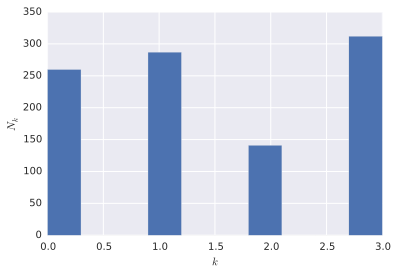

In [56]:
d = DiscreteDataset(1000, [ 0.25, 0.3, 0.15, 0.3 ])
plt.hist(d.values())
plt.xlabel("$k$")
plt.ylabel("$N_k$")
plt.show()

These values seem close enough to the "true" probabilities.

### Generating the network: the configuration model

In order the generate a network with the given degree distribution, we need to make use the the Monte Carlo method to create a set of nodes with the desired degrees. This again differs from the ER generator used before: rather then use a generating process that creates edges with a given degree distribution (Poisson in that case), we will instead generate the node degrees and then use these as the basis for creating the edges we need. In other words we *start* with the node degrees and *induce* the edges, rather than the other way round.

The technique is to create a set of nodes with edge "stubs" corresponding to the desired degree. We created these stubs using the desired degree distribution, drawing for each node a number from the distribution and creating that many stubs on the node. It is easy to see that this gives the right distribution of edge stubs. We then connect the edge stubs of pairs of nodes randomly, yielding a random graph with the desired degree distribution. (One small limitation is that the sum of the degree distributions has to be even, since each edge requires two edge stubs.)

We can encapsulate this as a single function for building a graph whose node degrees are taken from a dataset drawn from an arbitrary distribution:

In [57]:
def discrete_graph( dist ):
    """Generate a graph with node degrees taken from the given dataset"""
    
    # create the empty graph
    g = nx.Graph()
    
    # populate the graph with nodes, capturing the number of edge stubs
    # desired on each
    i = 0
    ws = []
    dsum = 0
    for dd in dist:
        v = g.add_node(i)
        if dd > 0:
            ws.append((i, dd))
            i = i + 1
            dsum = dsum + dd

    # if the sum of degrees is odd, bump the degree of a random node
    # (the assumption being that this will make little difference)
    if dsum % 2 <> 0:
        i = int(rnd.random() * len(ws))
        (v, d) = ws[i]
        ws[i] = (v, d + 1)
            
    # wire-up edges between random nodes according to the remaining edge stubs
    while len(ws) > 1:
        si = int(rnd.random() * len(ws))
        ei = si
        while ei == si:
            # avoid self-loops
            # sd: should we do this or not?
            ei = int(rnd.random() * len(ws))
            
        # add edge between chosen nodes
        (s, ss) = ws[si]
        (e, es) = ws[ei]
        g.add_edge(s, e)
        
        # reduce the edge stubs on both nodes
        if ss > 1:
            ws[si] = (s, ss - 1)
        else:
            ws.pop(si)
            if si < ei:
                ei = ei - 1
        if es > 1:
            ws[ei] = (e, es - 1)
        else:
            ws.pop(ei)

    # if we have a node left, forget it (the assumption being that
    # a deviation 1 from the distribution won't matter, which is true
    # for networks of thousands of nodes or more at least)
        
    return g

We can now use this function to build a graph with an arbitrary degree distribution given by a probability mass function using our `DiscreteDataset` class:

In [58]:
g = discrete_graph(DiscreteDataset(100, [ 0.25, 0.3, 0.15, 0.3 ]))

We can draw this graph to at least get an idea of how it is wired up:

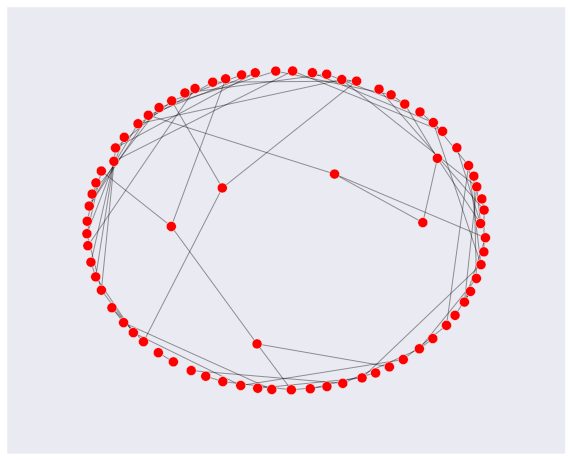

In [60]:
fig = plt.figure(figsize=(10, 8))
ax = fig.gca()
ax.set_xlim([-0.2, 1.2])      # axes bounded around 1
ax.set_ylim([-0.2, 1.2])
ax.grid(False)                # no grid
ax.get_xaxis().set_ticks([])  # no ticks on the axes
ax.get_yaxis().set_ticks([])

# run the spring layout algorithm over the network
pos = nx.spring_layout(g, iterations = 100, k = 2/math.sqrt(g.order()))

# draw the network using the computed positions for the nodes
nx.draw_networkx_edges(g, pos, width = 1, alpha = 0.4)
nx.draw_networkx_nodes(g, pos, node_size=100, alpha = 1, linewidths = 0.5)
plt.show()

Just to show that the approach works for *any* distribution, we can define a dataset sub-class that represents the Poisson distribution. Generating this graph should yield an ER network the same as was acquired using the earlier generating process &ndash; except now we start from the degree distribution and generate the network using a standard process, rather than starting with a generating process that results in nodes with Poisson degree: 

In [61]:
class PoissonDataset(Dataset):
    """Represent a dataset drawn against a Poisson distribution"""

    def __init__( self, n, k ):
        """Initalise the dataset with the given size and mean degree.
        
        n: the size of the dataset
        k: the mean degree of the underlying Poisson distribution"""
        super(PoissonDataset, self).__init__(n)
        self._meanDegree = k
        
    def _candidate( self ):
        """Generate a candidate value"""
        return int(rnd.random() * self._meanDegree * 2)
    
    def probabilityOf( self, v ):
        """The probability of a value appearing, taken from the
        underlying binomial distribution.
        
        v: the value
        rerurns: the probability of this value appearing"""
        return (pow(self._meanDegree, v) * math.exp(-self._meanDegree)) / math.factorial(v)

We can generate an ER network with 1000 nodes and mean degree 5 using:

In [62]:
g = discrete_graph(PoissonDataset(1000, 5))

Plotting this graph isn't particularly informative due to the density of information. However, we can plot the degree distribution to check that it looks Poisson:

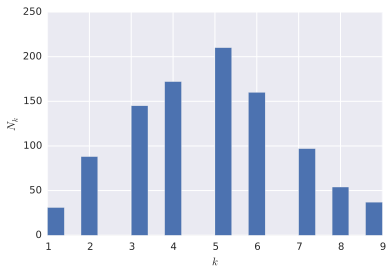

In [65]:
plt.hist(g.degree().values(), bins = 20)
plt.xlabel("$k$")
plt.ylabel("$N_k$")
plt.show()